169.79473495483398


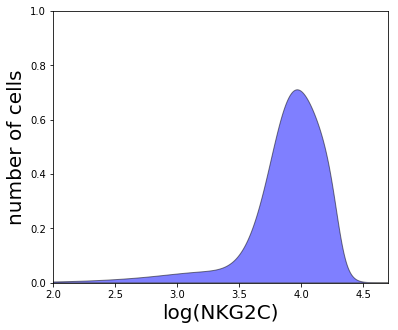

In [47]:
import numpy as np 
from matplotlib import cm
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from matplotlib import animation
import matplotlib
import time

start = time.time()

        
def tridiag(b,a,c,f):

    nf = len(f) # number of equations
    ac, bc, cc, fc = map(np.array, (a, b, c, f)) # copy arrays
    
    for i in range(1, nf):
        mc = ac[i-1]/bc[i-1]
        bc[i] = bc[i] - mc*cc[i-1] 
        fc[i] = fc[i] - mc*fc[i-1]
        
    xc = bc
    xc[-1] = fc[-1]/bc[-1]

    for j in range(nf-2, -1, -1):
        xc[j] = (fc[j]-cc[j]*xc[j+1])/bc[j]

    return xc


tsteps = 10000; #time steps
nsteps = 3000; #space steps
L = 50000;    #space size
tmax = 100;  #time size   ## 100 setmanes ---> dt = 0.01 setmanes ---> cada 100 unitats = 1 setmana

dt = tmax/tsteps;
dx = L/nsteps;       #grid discretization

alpha = 10000;
beta = 0.05;
g = 200;
k1 = 7000;     #PARAMETERS
k2 = 20000;
kv = 1;
mu0 = 0.1;
lambda0 = 0.4;
k = 0.0000000;
v1 = 3;
v2 = 1;
v3 = 0.008;

p = 4; #hill coefficients
q = 10;
sigma = 10;

dif = ((beta*sigma)**2)/2; #diffusion

x = np.linspace(dx,L,nsteps);
t = np.linspace(0,tmax,tsteps);

B = np.zeros(nsteps);
C = np.zeros(nsteps);
A = np.zeros(nsteps);

lamb = np.zeros(nsteps);     #function initialization
llambda = np.zeros(nsteps);
f = np.zeros(nsteps);
mu = np.zeros(nsteps);
n = np.zeros((nsteps,tsteps));
S = np.zeros((nsteps,tsteps));
J = np.zeros((nsteps,tsteps));   #flux

n[:,1] = 100*lognorm.pdf(x, 1, loc=0, scale=2500);   #initial distribution


#plt.plot(np.log10(x), n[:,1])   #distribució inicial
#plt.axis([1,5,0,0.001])
#plt.show()

v = 0;
N = np.trapz(x,n[:,1]); 

ims = []
    
fig, ax = plt.subplots(figsize=(6,5))

for m in range(1,1000): #time loop 
    
    B[0] = 2/dt;
    A[0] = alpha/(4*dx);
    C[0] = 0;
    S[0,m] = -A[0]*n[1,m] + (2/dt - B[0])*n[0,m];
    
       
    B[nsteps-1] = 0;
    A[nsteps-1] = 0;
    C[nsteps-1] = 1;
    S[nsteps-1,m] = -n[nsteps-1,m];
    
    r = 0;
    
    if m < 200:
        v = 0
    else:
        v = v1 + v2*(m-200)*np.exp(-v3*(m-200)); 
    
#     
#     elseif (m>=200) && (m<600)
#     v = v1 + v2*(m-200)*np.exp(-v3*(m-200));  %% PER POSAR MES VIRUS
#     else
#     v = v1 + v2*(m-200)*np.exp(-v3*(m-200)) + v2*(m-600)*np.exp(-v3*(m-600)); 
#     end     
    r = 0
    
    for i in range(1,nsteps-1):
        
        r = r + dx;
        
    #   if r < 3000:
    #       k=0.00000005;   %maybe different carrying capacities for dim/bright
    #   else:
    #       k=0.000001;

        f[i] = alpha - beta*r;
        
        lamb[i] = lambda0*(1 + g*(v/(kv+v))*(r**p)/(k1**p + r**p));
        #llambda[i] = lambda0*(1 + 0*(v/(kv+v))*(r**p)/(k1**p + r**p))/(1+(r/kappa)**q);
        mu[i] = mu0;
    
        B[i] = 1/dt + (-beta-dif)/2 + r*r*dif/(dx**2) - (-mu[i]-k*N)/2;
        C[i] = -(f[i]-3*dif*r)/(4*dx) - r*r*dif/(2*dx**2);
        A[i] = (f[i]-3*dif*r)/(4*dx) - r*r*dif/(2*dx**2);
        
            
        S[i,m] = -A[i]*n[i+1,m] + (2/dt - B[i])*n[i,m] - C[i]*n[i-1,m] + lamb[i]/(1+(r/k2)**q);
        

    n[:,m+1] = tridiag(B[:],C[:],A[:],S[:,m]);
    
    #r = 0;
    #for i in range(1,nsteps-1):
    #    r = r + dx;
    #    J[i,m] = (f[i]-dif*r)*((n[i,m+1]) + n[i,m])/2 - dif*r*r*(n[i+1,m]-n[i-1,m]+n[i+1,m+1]-n[i-1,m+1])/(4*dx);
     
    #N = np.trapz(x,n[:,m]); 
    
    im = ax.fill_between(np.log10(x),n[:,m], edgecolor = 'k', facecolor = 'b', alpha = 0.5)
    plt.axis([2,np.log10(L),0,1])
    ax.set_ylabel('number of cells', fontsize = 20)
    ax.set_xlabel('log(NKG2C)', fontsize = 20)
    
    ims.append([im])
    
writer = animation.FFMpegWriter(fps = 50, codec="libx264", bitrate=-1, extra_args=['-pix_fmt', 'yuv420p'])
ani = animation.ArtistAnimation(fig,ims, blit = True)
ani.save('nk_video.mp4',writer = writer, dpi = 200)
    
#ax.fill_between(np.log10(x),n[:,1], facecolor = 'b', alpha = 0.5)
#plt.axis([1,np.log10(L),0,5])
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.axis([0,L,0,200])
#ax.set_ylabel('number of cells', fontsize = 20)
#ax.set_xlabel('log(NKG2C)', fontsize = 20)
#plt.savefig("final_distribution.pdf", bbox_inches="tight")

#plt.figure()

#plt.plot(np.log10(x),mu,'b', linewidth = 2)
#plt.plot(np.log10(x),lamb,'r', linewidth = 2)
#plt.xlabel('log fluorescence (au)', fontsize = 16)
#plt.ylabel('growth death rate', fontsize = 16)
#plt.axis([2.6, 4.5, 0, 0.1])

 
#T = np.linspace(0,tsteps-1,tsteps)
#X = np.linspace(dx,L,nsteps)

#XX, TT = np.meshgrid(X, T)

#plt.pcolormesh(np.log10(XX), TT, np.transpose(n), cmap = 'RdBu_r', shading='gouraud');
#plt.ylabel('log fluorescence','fontsize', 15)
#plt.xlabel('time(weeks)','fontsize', 15)
#plt.colorbar()

#plt.show()

end = time.time()

print(end - start)